In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Read CSV files into dataframes
ackermann = pd.read_csv('./DataBags/drifting3_3/ackermann_drift.csv')
odom = pd.read_csv('./DataBags/drifting3_3/odomfil_drift.csv')
unfiltered_odom = pd.read_csv('./DataBags/drifting3_3/odom_drift.csv')
imu = pd.read_csv('./DataBags/drifting3_3/imu_drift.csv')

In [3]:
ackermann.head()

,sec,nanosec,frame_id,steering_angle,steering_angle_velocity,speed,acceleration,jerk
0,1741043534,969994961,NaN,-0.185016,0.0,1.218788,0.0,0.0
1,1741043535,24867084,NaN,-0.185016,0.0,1.218788,0.0,0.0
2,1741043535,75703450,NaN,-0.185016,0.0,1.218788,0.0,0.0
3,1741043535,127527539,NaN,-0.185016,0.0,1.218788,0.0,0.0
4,1741043535,178827719,NaN,-0.185016,0.0,1.218788,0.0,0.0


In [4]:
# Some data is out of order, so they get sorted by time
ackermann_sorted = ackermann.sort_values(['sec','nanosec'], ignore_index=True)
odom_sorted = odom.sort_values(['sec', 'nanosec'], ignore_index=True)
throttle_sorted = unfiltered_odom.sort_values(['sec', 'nanosec'], ignore_index=True)
imu_sorted = imu.sort_values(['sec', 'nanosec'], ignore_index=True)

KeyError: 'sec'

In [ ]:
# Create a new column combined time
ackermann_sorted['time'] = ackermann_sorted['sec']+ackermann_sorted['nanosec']*1e-9
odom_sorted['time'] = odom_sorted['sec']+odom_sorted['nanosec']*1e-9
throttle_sorted['time'] = throttle_sorted['sec']+throttle_sorted['nanosec']*1e-9
imu_sorted['time'] = imu_sorted['sec']+imu_sorted['nanosec']*1e-9

In [ ]:
#odom_sorted.head()

In [ ]:
tables = [ackermann_sorted, odom_sorted, throttle_sorted, imu_sorted]

# Initialize new dataframes for interpolated versions of the original tables
ackermann_sorted_interpolated = pd.DataFrame()
odom_sorted_interpolated = pd.DataFrame()
throttle_sorted_interpolated = pd.DataFrame()
imu_sorted_interpolated = pd.DataFrame()

# Names of new interpolated tables
new_tables = [ackermann_sorted_interpolated, odom_sorted_interpolated, throttle_sorted_interpolated, imu_sorted_interpolated]

# Initialize time relative to the earlies message so none of the tables have negative time
t_0 = throttle_sorted['time'][0]

for table, new_table in zip(tables,new_tables):
    for column in table.select_dtypes(include=[np.number]).columns:
        new_table[column] = np.interp(np.linspace(0, 1, len(odom_sorted['time'])), np.linspace(0, 1, len(table[column])), table[column])
    
    # Initialize relative of all new tables to time[0] of ackermann_sorted_interpolated
    new_table['time'] -= t_0
    print(len(new_table))
    print(new_table['time'][0])
    


1040
-0.07885026931762695
1040
-1.1226661205291748
1040
0.0
1040
1.0800130367279053


In [ ]:
throttle = ackermann_sorted_interpolated['speed']

In [ ]:
imu_sorted_interpolated['twist_angular_z'] = np.deg2rad(imu_sorted['twist_angular_z'])

#odom_sorted = odom_sorted.drop(odom_sorted.index[odom_sorted['sec'] > 36])
#throttle_sorted = throttle_sorted.drop(throttle_sorted.index[throttle_sorted['sec'] > 36])
#throttle_sorted = throttle_sorted.drop(throttle_sorted.index[throttle_sorted['nanosec'] > odom_sorted.loc[odom_sorted.index[-1]]['nanosec']])

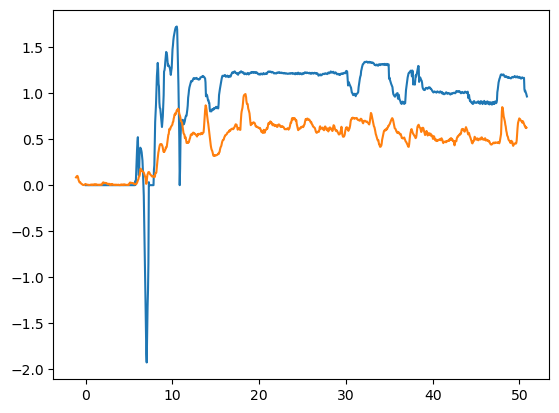

In [ ]:
# Twist Magnitude
plt.plot(throttle_sorted_interpolated['time'], throttle_sorted_interpolated['twist_linear_x'])
plt.plot(odom_sorted_interpolated['time'], np.sqrt((odom_sorted_interpolated['twist_linear_y'] ** 2) + (odom_sorted_interpolated['twist_linear_x'] ** 2)))

In [ ]:
linear_vel_diff = 
plt.plot(odom_sorted_interpolated['time'], np.sqrt((odom_sorted_interpolated['twist_linear_y'] ** 2) + (odom_sorted_interpolated['twist_linear_x'] ** 2)))

SyntaxError: invalid syntax (2967785203.py, line 1)

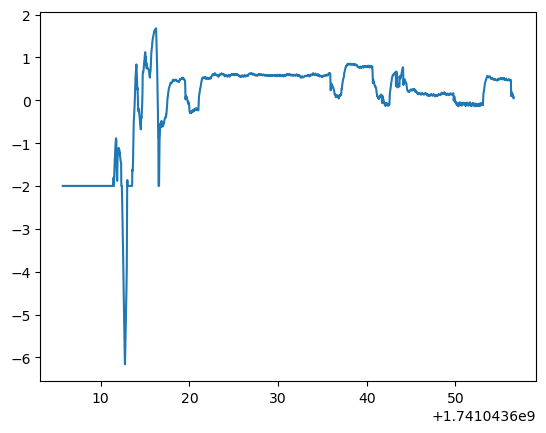

In [ ]:
from sklearn.preprocessing import StandardScaler
from math import atan2, asin

# Scale throttle['speed'] and odom velocity
scaler = StandardScaler()
scaler.fit(throttle_sorted['twist_linear_x'].values.reshape(-1, 1))
throttle_scaled = scaler.transform(throttle_sorted['twist_linear_x'].values.reshape(-1, 1)).squeeze(axis=-1)

# Combine x and y
odom_comb = np.sqrt((odom_sorted['twist_linear_y'] ** 2) + (odom_sorted['twist_linear_x'] ** 2))

scaler.fit(odom_comb.values.reshape(-1, 1))
odom_scaled = scaler.transform(odom_comb.values.reshape(-1, 1)).squeeze(axis=-1)

# Resample to same length
odom_scaled = np.interp(np.linspace(0, 1, len(throttle_scaled)), np.linspace(0, 1, len(odom_scaled)), odom_scaled)
odom_position_x = np.interp(np.linspace(0, 1, len(throttle_scaled)), np.linspace(0, 1, len(odom_sorted['position_x'])), odom_sorted['position_x'])
odom_position_y = np.interp(np.linspace(0, 1, len(throttle_scaled)), np.linspace(0, 1, len(odom_sorted['position_y'])), odom_sorted['position_y'])

imu_twist_angular_z = np.interp(np.linspace(0, 1, len(odom_sorted)), np.linspace(0, 1, len(imu_sorted['twist_angular_z'])), imu_sorted['twist_angular_z'])

# Conver to yaw
yaws = []
for qx, qy, qz, qw in zip(odom_sorted['orientation_x'], odom_sorted['orientation_y'], odom_sorted['orientation_z'], odom_sorted['orientation_w']):
    yaw = atan2(2.0*(qy*qz + qw*qx), qw*qw - qx*qx - qy*qy + qz*qz)
    pitch = asin(-2.0*(qx*qz - qw*qy))
    roll = atan2(2.0*(qx*qy + qw*qz), qw*qw + qx*qx - qy*qy - qz*qz)
    yaws.append(yaw)

yaws = np.interp(np.linspace(0, 1, len(throttle_scaled)), np.linspace(0, 1, len(yaws)), yaws)

odom_orientation_x = np.interp(np.linspace(0, 1, len(throttle_scaled)), np.linspace(0, 1, len(odom_sorted['orientation_x'])), odom_sorted['orientation_x'])
odom_orientation_y = np.interp(np.linspace(0, 1, len(throttle_scaled)), np.linspace(0, 1, len(odom_sorted['orientation_y'])), odom_sorted['orientation_y'])
odom_orientation_z = np.interp(np.linspace(0, 1, len(throttle_scaled)), np.linspace(0, 1, len(odom_sorted['orientation_z'])), odom_sorted['orientation_z'])

plt.plot((throttle_sorted['sec'] + throttle_sorted['nanosec'] * 10**-9), throttle_scaled)
#plt.plot((throttle_sorted['sec'] + throttle_sorted['nanosec'] * 10**-9), odom_scaled)

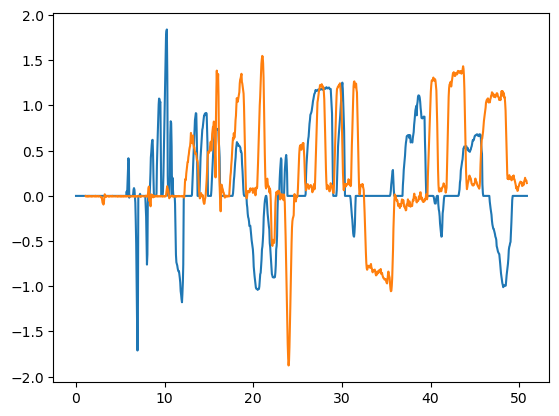

In [ ]:
# Yaw Rates
import numpy as np
wheelbase = 0.32
tire_width = 0.04445

turning_radius = np.tan(ackermann_sorted_interpolated['steering_angle'])/wheelbase
theoretical_angular_velocity = throttle_sorted_interpolated['twist_linear_x']*turning_radius

plt.plot(throttle_sorted_interpolated['time'], theoretical_angular_velocity)
#plt.plot(throttle_sorted_interpolated['time'], ackermann_sorted_interpolated['steering_angle'])
plt.plot(imu_sorted_interpolated['time'], imu_sorted_interpolated['twist_angular_z'])

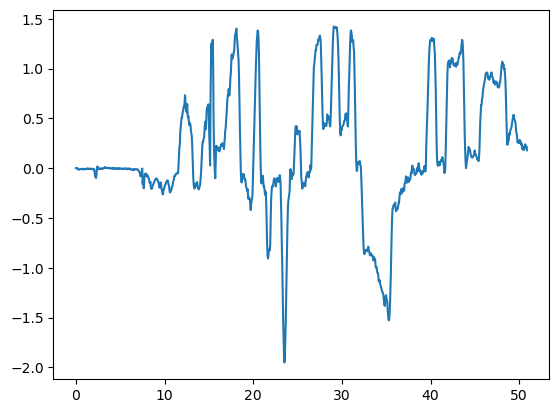

In [ ]:
plt.plot(throttle_sorted_interpolated['time'], (imu_sorted_interpolated['twist_angular_z'] - odom_sorted_interpolated['twist_angular_z']))

#yaw_difference = throttle_sorted['twist_angular_z'] - odom_sorted['twist_angular_z']

In [ ]:
len(imu_position_z)

737

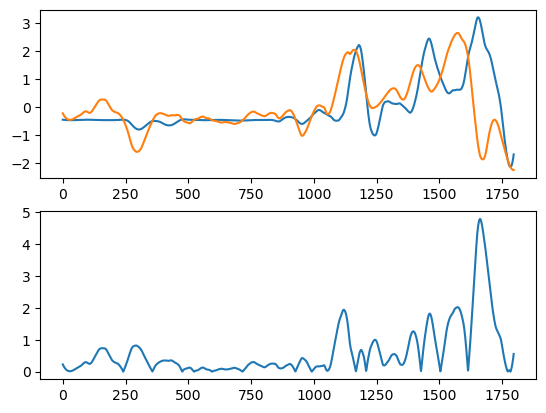

In [ ]:
# Plot the difference
from scipy.signal import savgol_filter

fig, axs = plt.subplots(2)

axs[0].plot(savgol_filter(throttle_scaled, 101, 3))
axs[0].plot(savgol_filter(odom_scaled, 101, 3))

axs[1].plot(np.abs(savgol_filter(throttle_scaled, 101, 3) - savgol_filter(odom_scaled, 101, 3)))

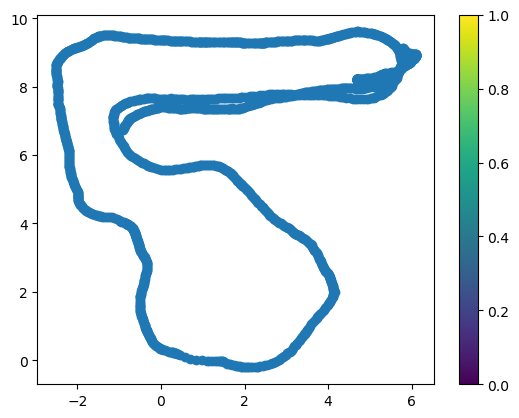

In [ ]:
plt.scatter(odom_position_x, odom_position_y, cmap=(yaw_difference))
plt.colorbar()

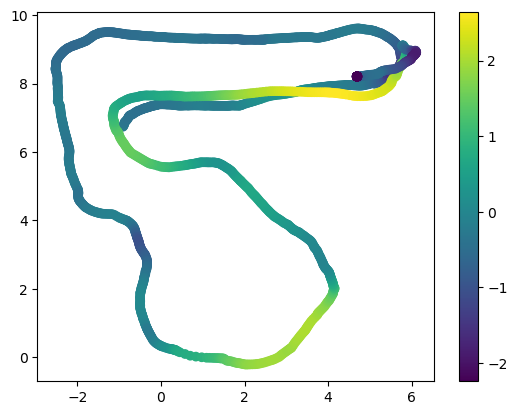

In [ ]:
plt.scatter(odom_position_x, odom_position_y, c=(savgol_filter(odom_scaled, 101, 3)))
plt.colorbar()

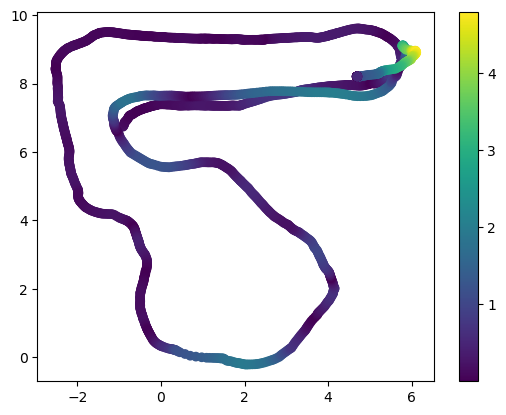

In [ ]:
plt.scatter(odom_position_x, odom_position_y, c=(np.abs(savgol_filter(throttle_scaled, 101, 3) - savgol_filter(odom_scaled, 101, 3))))
plt.colorbar()